In [1]:
""" Quick analizer for the station 0-20000-0-10962 
      focus on the date '2014-12-10T06:00:00.000000000', '2014-12-10T06:00:28.000000000' 
      i.e. two distinct records only 28 seconds apart.
      This originates from the merging of NCAR and ERA5 data """

import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import ticker
import os,sys
import matplotlib.pylab as plt
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial
import datetime

#matplotlib.use('Agg')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


os.system('rm output_all_merged/failed_files.txt')

""" Class holding general properties of the plots """
class Common():
    def __init__(self):
        
        """ For plotting style """
        style_dic = {85 : { 'l': 'Air Temperature [K]'         , 'c': 'blue'      } , 
                     117: { 'l': 'Geopotential [m]'            , 'c': 'green'     } ,
                     104: { 'l': 'Wind u-component [m/s]'      , 'c': 'gold'      } ,
                     105: { 'l': 'Wind v-component [m/s]'      , 'c': 'limegreen' } ,
                     107: { 'l': 'Wind speed [m/s]'            , 'c': 'black'     } ,
                     106: { 'l': 'Wind from direction'         , 'c': 'cyan'      } ,    
                    }
    
        datasets_dic = {'era5_1'     : { 'l': 'ERA5 1'    , 'c': 'blue'      } ,
                        'era5_2'     : { 'l': 'ERA5 2'    , 'c': 'limegreen' } ,
                        'ncar'       : { 'l': 'NCAR'      , 'c': 'purple'    } ,
                        'igra2'      : { 'l': 'IGRA2'     , 'c': 'cyan'      } ,
                        'era5_1759'  : { 'l': 'ERA5 1759' , 'c': 'gray'      } ,
                        'era5_1761'  : { 'l': 'ERA5 1761' , 'c': 'pink'      } ,
                        'era5_3188'  : { 'l': 'ERA5 3188' , 'c': 'yellow'    } ,
                        'bufr'       : { 'l': 'BUFR'      , 'c': 'green'     } ,
                    }
        
        self.style_dic    = style_dic
        self.datasets_dic = datasets_dic 
        self.std_plevs    = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000]
        self.fontsize     = 15
        self.datasets     = ["era5_1" , "era5_2" , "era5_1759" , "era5_1761" , "era5_3188" , "bufr" , "ncar" , "igra2" ]
        
        
Common = Common()

""" Standard pressure levels in hPa """
std_plevs = Common.std_plevs

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
def analyze_header(force , file):
    """ Reads the header_table and recordindex from the input file, return various lists """
    data = {}
    #print('file is ++++++ ' ,  file )
    #columns = ['latitude' , 'longitude', 'report_id' , 'source_id' , 'duplicates' , 'report_timestamp' , 'record_timestamp']
    columns = ['source_id' , 'report_timestamp'  ]
    if force:
        try:

            ht    = xr.open_dataset (file, engine = 'h5netcdf' , group = "header_table", decode_times = False ).to_dataframe()
            ri    = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = True )['recordindex']
            rts_d = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = True )['recordtimestamp'].values
            rts_o = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = False)['recordtimestamp'].values

            dictionary = dict( zip( list(rts_o), list(rts_d) ) ) 


            ht = ht [columns]

            """
            for i, j in ht.iterrows():            
                datetime = np.datetime64(j.report_timestamp)  
                
                if type(datetime) != np.datetime64: # some old header table do not have the units appended to the report_timestamps are not voncerted autom. to date_time objects
                    datetime = dictionary[datetime]

                id = (j.source_id).decode("utf-8")
                try:
                    data[id].append(datetime)            
                except:
                    data[id] = []
                    data[id].append(datetime)            
            """
            for i, j in ht.iterrows():            
                datetime = dictionary[j.report_timestamp]  # casting to numpy datetime64 object
                y = pd.to_datetime(datetime).year
                id = (j.source_id).decode("utf-8")
                try:
                    data[id].append(y)            
                except:
                    data[id] = []
                    data[id].append(y)   
            
            

        except:
            out = open('output_all_merged/failed_files.txt' , 'a+')
            out.write(file + '\n')
            print("Failed::: " , file )

        return data
    
    else:
        #print(" ********** Running in normal mode, force = " , force)     
        ht    = xr.open_dataset (file, engine = 'h5netcdf' , group = "header_table", decode_times = False ).to_dataframe()
        ri    = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = True )['recordindex']
        rts_d = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = True )['recordtimestamp'].values
        rts_o = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = False)['recordtimestamp'].values

        dictionary = dict( zip( list(rts_o), list(rts_d) ) ) 

        ht = ht [columns]

        for i, j in ht.iterrows():            
            datetime = dictionary[j.report_timestamp]  # casting to numpy datetime64 object
            y = pd.to_datetime(datetime).year
            id = (j.source_id).decode("utf-8")
            try:
                data[id].append(y)            
            except:
                data[id] = []
                data[id].append(y)            
        return data


In [4]:
""" Directory to be processed """
merged_directory = '/raid60/scratch/federico/JULY_MERGE'

files_list = [ merged_directory + '/' + f  for f in os.listdir(merged_directory) ][:]

all_data = {'era5_1'    :[],
            'era5_2'    :[],
            'era5_1759' :[],
            'era5_1761' :[],
            'era5_3188' :[],
            'bufr'      :[],
            'igra2'     :[],
            'ncar'      :[], }

force = True
p    = Pool(20)
func = partial(analyze_header, force)
out  = p.map(func, files_list)

# putting all the output (i.e. the dtae_time of each record per dataset) together:
for o in tqdm(out):
    for k in o.keys():
        all_data[k] += o[k]    

np.save('all_records_data_TODAY', all_data)


#print(all_data)


Failed:::  /raid60/scratch/federico/JULY_MERGE/0-20000-0-62131_CEUAS_merged_v0.nc


100%|██████████| 6849/6849 [00:02<00:00, 3210.41it/s] 


In [5]:
def plot_dataset_distribution(results, year_min='', year_max=''):
    """ Make a histogram for the distribution of date time availabe for each dataset, both separated and stacked """
    num_sources = len(results.keys() )
    datasets_dic = Common.datasets_dic
    os.system('mkdir output_all_merged ')
    
    fs = 20
    
    if year_min:
        fig, ax = plt.subplots(figsize=(20,6) ) #    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(15,10) )
    else:
        fig, ax = plt.subplots(figsize=(12,10) ) 
        
    """ Creating the list for the stacked histogram """
    ticks, labels, X, colors = [], [], [], []
    Min, Max = [], [] 
    
    for d, dt in results.items() :
        label = datasets_dic[d]['l'] + "  [" + str(len(dt)) + "]"
        labels.append(label)
        colors.append(datasets_dic[d]['c'] )
        try:
            X.append(dt)
            Min.append(min(dt))
            Max.append(max(dt))
        except:
            pass


    def properties():
        plt.title("Records Distribution CEUAS Database v1 " , y = 1.03, fontsize = fs  )    
        plt.ylabel("Record counts " , fontsize = fs)
        plt.xticks(rotation = 45 , fontsize = fs  )
        plt.yticks(fontsize = fs  )
        ax.grid(ls =":" , color = "lightgray")
        y_min = np.array ( [min(Min)] )
        y_max = np.array ( [max(Max)] )
        nbins = int(y_max) - int(y_min)
        if year_min and year_max:
            plt.xlim(year_min, year_max)
            
        return y_min, y_max , int(nbins/4,)
        
    if year_min:
        fig, ax = plt.subplots(figsize=(18,12) ) #    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(15,10) )
    else:
        fig, ax = plt.subplots(figsize=(12,10) )    
    y_min, y_max , nbins = properties()
    
    nbins = 40
    plt.hist(X, nbins, histtype='bar', stacked=True, label=labels, color = colors )
    plt.legend(fontsize = fs  , loc = 'best' )    
    plt.savefig("output_all_merged/record_distribution_stacked.png", bbox_inches = 'tight' , dpi = 250 )     
    plt.show()
    plt.close()

    if year_min:
        fig, ax = plt.subplots(figsize=(20,6) ) #    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True , figsize=(15,10) )
    else:
        fig, ax = plt.subplots(figsize=(12,10) )
        
    nbins = 40

    plt.hist(X, nbins, histtype='step', stacked=False, label=labels, color = colors )
    y_min, y_max , nbins = properties()    
    plt.legend(fontsize = fs  , loc = 'best' )
    plt.savefig("output_all_merged/record_distribution.png", bbox_inches = 'tight' , dpi = 250 )     
    plt.show()
    plt.close()
    

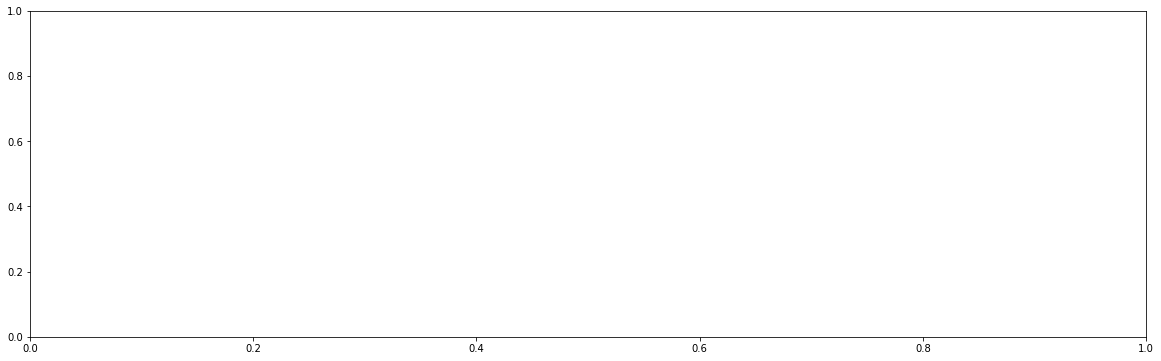

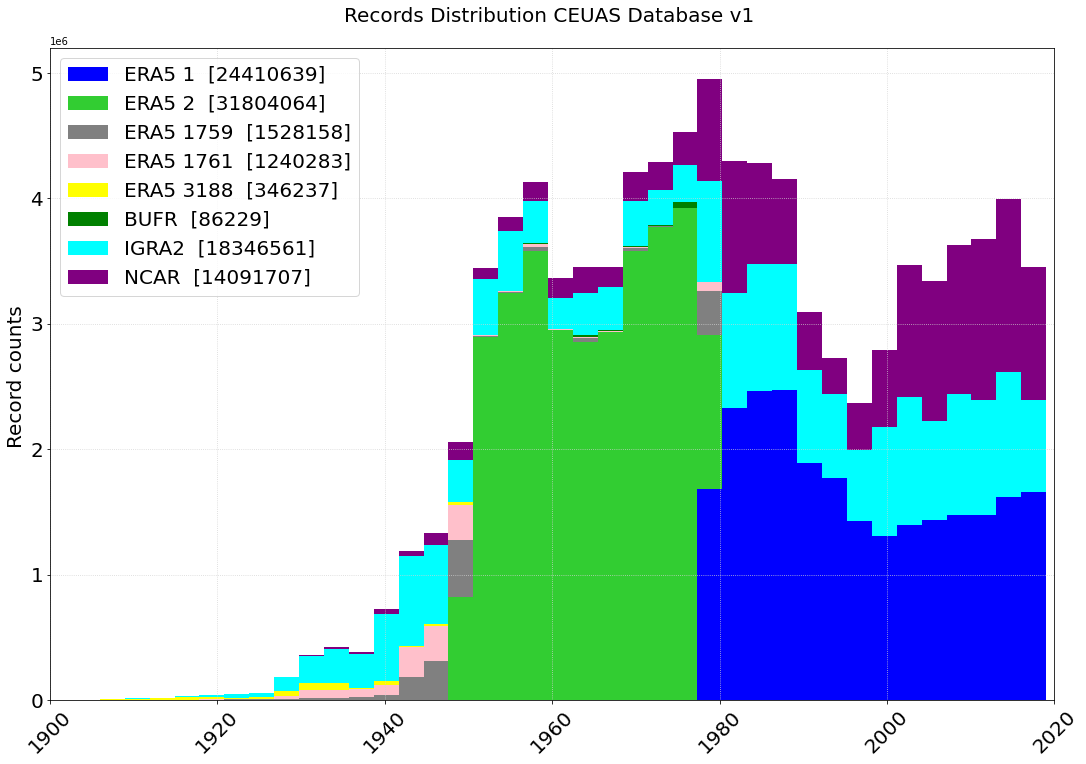

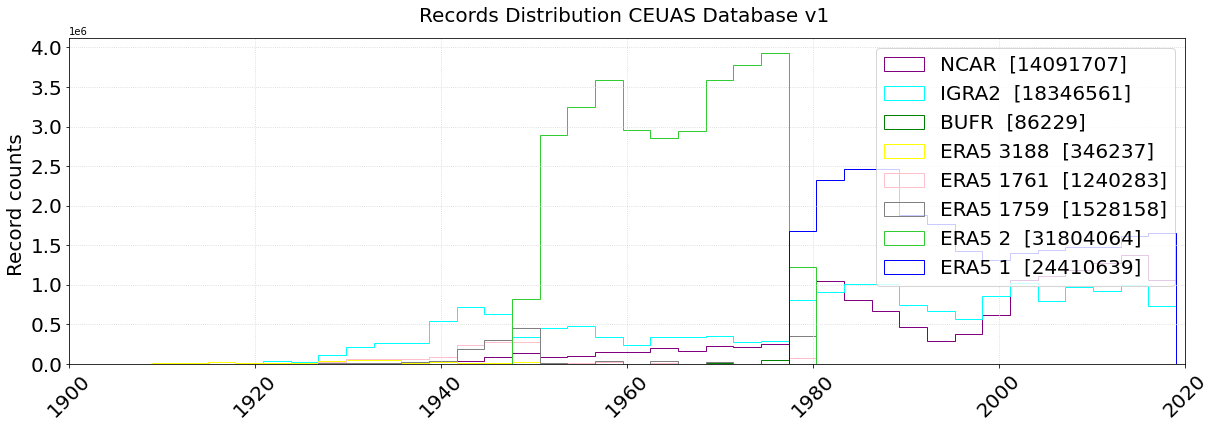

In [6]:
dm , DM = datetime.datetime(1900,1,1,0,0) , datetime.datetime(2020,1,1,0,0)

y_min , y_max = 1900 , 2020 
p = plot_dataset_distribution (all_data, year_min = y_min , year_max = y_max )  